# Aplicação de modelos de classificação:

---

Autor: Enzo Bustos da Silva

Adult dataset pode ser encontrado:

*   [Uci Repository](https://archive.ics.uci.edu/ml/datasets/Adult)
*   [Kaggle](https://www.kaggle.com/c/adult-pmr3508/data)

Nesse notebook vamos discutir a aplicação de alguns algoritmos de classificação aplicados no dataset adult, esse dataset consta de várias informações como ocupação, nível de educação, entre outras e, tem como objetivo determinar se uma pessoa terá uma renda maior ou menor que 50K anuais, com base nessas outras observações.

No primeiro trabalho do curso utilizamos esse mesmo dataset para testar o modelo KNN, por conta disso usarei as mesmas técnicas já utilizadas para limpar e visualizar os dados e por último testarei os diversos modelos e farei uma comparação entre eles.


# Importando Dados:

---

Nessa parte vamos conectar nosso notebook ao Google Drive (para o caso do Colab) ou importar nossos dados diretamente da plataforma do Kaggle, em seguida vamos carregá-los utilizando `pandas`.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=1)

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Poli/Aprendizado de Máquina/EPs/EP4 - Classificação'

/content/drive/MyDrive/Poli/Aprendizado de Máquina/EPs/EP4 - Classificação


In [3]:
import numpy as np
import pandas as pd

col_names = ["Age", "Workclass", "Final Weight", "Education", "Education-Num",
             "Marital Status", "Occupation", "Relationship", "Race", "Sex",
             "Capital Gain", "Capital Loss", "Hours per week", "Country", "Income"]

df = pd.read_csv('train_data.csv', index_col='Id', na_values='?')
df.columns = col_names

# Observações iniciais:

---

Nessa parte vamos tentar analisar quais vão ser nossas diretrizes de análise, ver se existem outliers ou dados faltantes, algo mais no "olhômetro" mesmo e pegar um pouco das primeiras impressões do dataset.

In [4]:
df.head(10)

,Age,Workclass,Final Weight,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K
16285,57,Private,163047,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,38,United-States,<=50K
16286,21,Private,197050,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,35,United-States,<=50K
16287,25,Private,288519,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16288,53,Private,260106,HS-grad,9,Widowed,Sales,Not-in-family,White,Female,0,0,30,United-States,<=50K


Com o head podemos ter um overview sobre exatamente o que estamos trabalhando, logo de cara já podemos ver que muito provavelmente precisaremos de uma normalização por conta da escala de alguns dados e existem algumas features categóricas que precisam ser trabalhadas de uma forma especial, fora isso podemos perceber que as colunas Capital Gain/Loss aparentam ser um pouco estranhas com tantos valores nulos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32560 entries, 16280 to 48839
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       30724 non-null  object
 2   Final Weight    32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education-Num   32560 non-null  int64 
 5   Marital Status  32560 non-null  object
 6   Occupation      30717 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital Gain    32560 non-null  int64 
 11  Capital Loss    32560 non-null  int64 
 12  Hours per week  32560 non-null  int64 
 13  Country         31977 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


Com o info podemos ver que Workclass, Occupation e Country apresentam dados faltante e que provavelmente terá que ser pensado algum modo de se lidar com ele ou simplesmente ignorá-los

In [6]:
df.describe()

,Age,Final Weight,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Com o describe numérico conseguimos ver o grande problema das colunas Capital Gain e Capital Loss, elas apresentam quase em sua totalidade valores de zeros, a coluna Final Weight também apresenta alguns valores grandes, provavelmente será preciso normalizar esses dados

In [7]:
df.describe(include='object')

,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country,Income
count,30724,32560,32560,30717,32560,32560,32560,31977,32560
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


Agora com o describe categórico podemos ter um pouco das distribuições das classes, mas iremos checar mais para frente com um pouquinho de visualização de dadados

# Visualização dos dados:

---

Nunca é demais um pouco de visualização de dados para entender um pouco do nosso problema, principalmente para as colunas com dados faltantes ('Workclass', 'Occupation' e 'Country') isso é essencial para pensarmos uma abordagem para nossos dados

Acho justo conferirem [esse link](https://medium.com/turing-talks/como-visualizar-e-analisar-dados-com-python-f209bfbae68e) para ter uma melhor ideia sobre visualização de dados

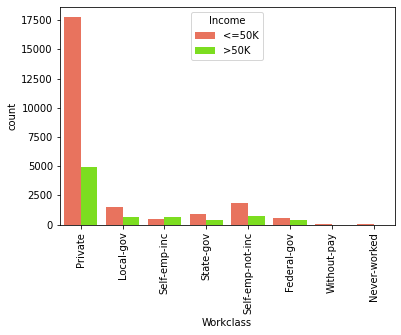

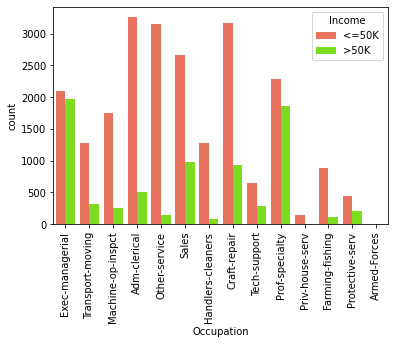

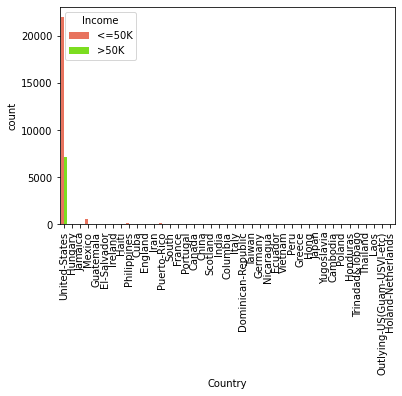

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

with_na = ['Workclass', 'Occupation', 'Country']

colors = {
    '<=50K': 'tomato',
    '>50K' : 'lawngreen'
}

for col in with_na:
    graf = sns.countplot(x=col, data=df, hue='Income', palette=colors)
    graf.set_xticklabels(graf.get_xticklabels(), rotation=90)
    plt.show()

Podemos ver algumas discrepâncias muito boas dentre esses dados faltantes, como por exemplo em 'Country' temos quase a totalidade de dados remetendo a United-States, ou seja, talvez essa categoria, seja meio supérflua no quesito que basicamente qualquer dado que não seja pertencente a esse país seria um outlier

Também podemos ter alguns insights interessantes a respeito de 'Workclass' ainda mais pela discrepância entre pessoas com mais de 50K dependendo da categoria

In [9]:
for col in with_na:
    print('-'*15 + ' ' + col + ' ' + '-'*15)
    print()
    print(df[col].value_counts())
    print()

--------------- Workclass ---------------

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1297
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: Workclass, dtype: int64

--------------- Occupation ---------------

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3769
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: Occupation, dtype: int64

--------------- Country ---------------

United-States                 29169
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador          

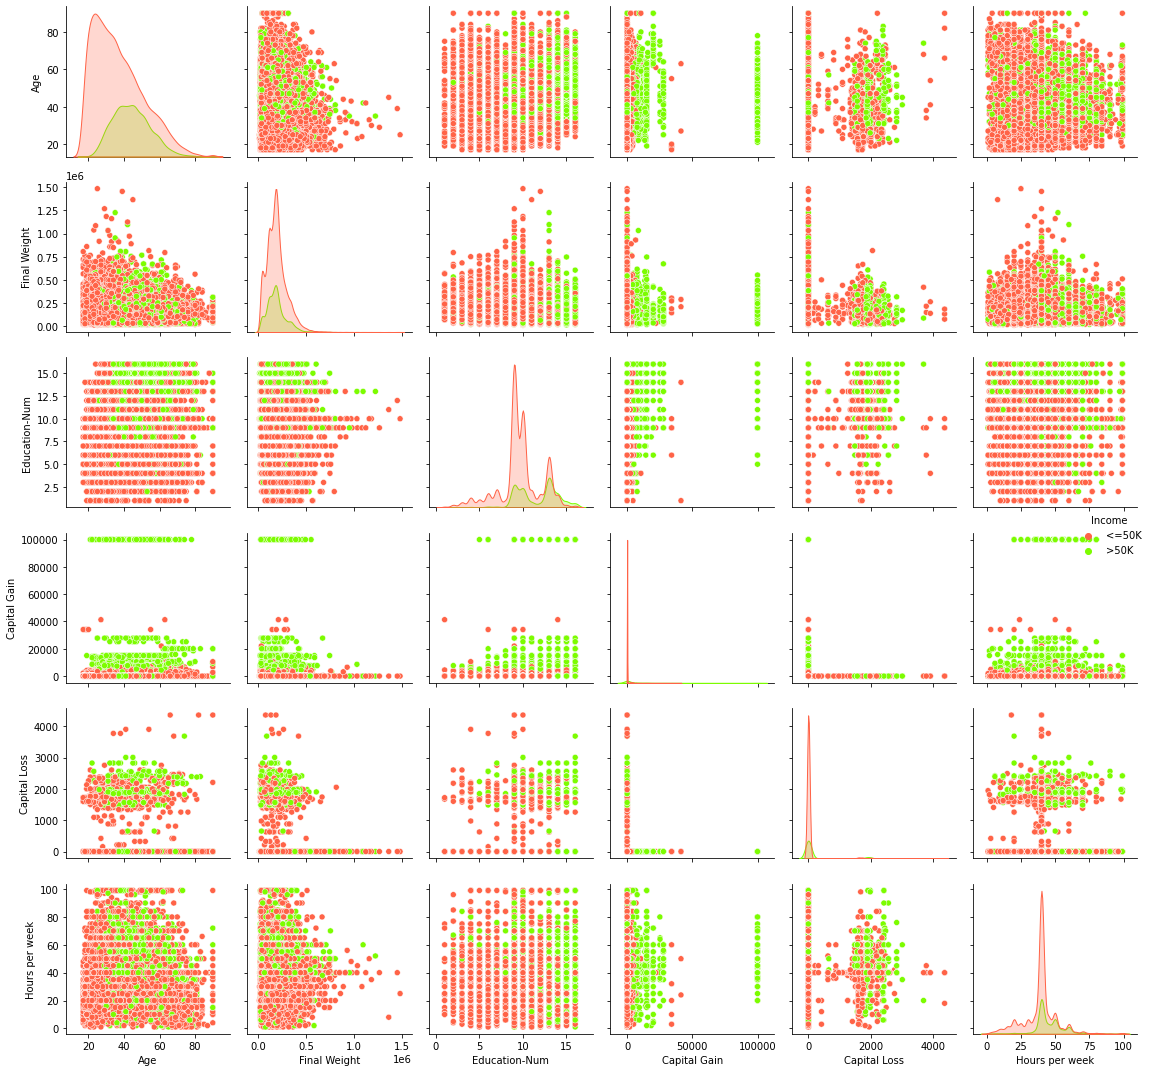

In [10]:
sns.pairplot(df, hue='Income', palette=colors)
plt.tight_layout()
plt.show()

Certo, vamos por partes que o pairplot é um pouco complexo, ele faz todas as combinações 2 a 2 das nossas features, nesse caso eu ainda pintei com o hue entre os dados que apresentam mais de 50K de renda com laranja e com menos de azul.

Na diagonal podemos ver a distribuição entre os dados o que mostra algumas tendências interessantes: 

*   Pessoas mais velhas tendem a ter uma maior renda
*   Final Weight não parece ser um valor determinante na renda
*   Pessoas com maior renda estão concentradas em um maior eduacational-num, mas a distribuição é semelhante com pessoas com menos renda
*   Pessoas com alto capital gain recebem mais de 50K, mas a recíproca é falsa
*   As formas de capital loss são semelhantes
*   Horas por semana é semelhante não importando sua renda

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

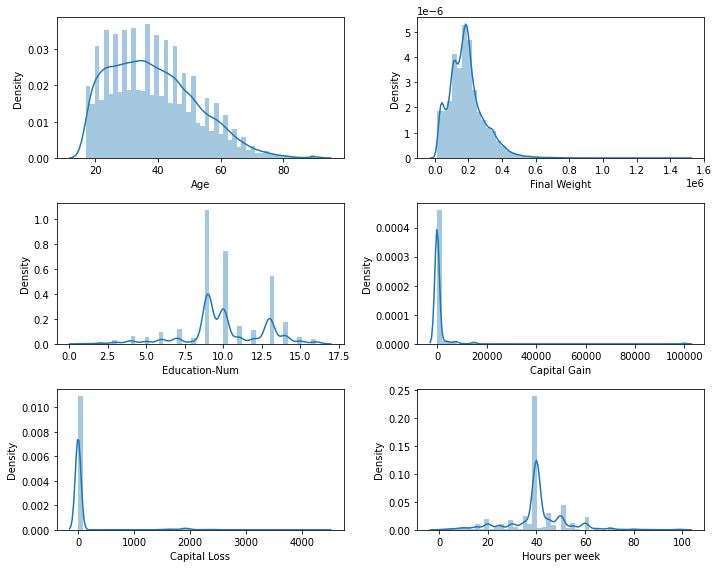

In [11]:
cols = ['Age', 'Final Weight', 'Education-Num',
        'Capital Gain', 'Capital Loss', 'Hours per week']

plt.figure(figsize=(10,8))
for i in range(len(cols)):
    plt.subplot(3, 2, i+1)
    sns.distplot(df[cols[i]])
plt.tight_layout()
plt.show()

Podemos agora dar uma olhada em algumas das distribuições das features e, quase por desencargo de consciência vamos plottar o heatmap das nossas variáveis numéricas, mas vamos ver que elas quase não tem uma relação forte entre si

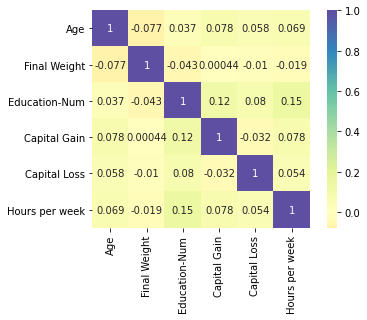

In [12]:
corr = df.corr()
sns.heatmap(corr, square=True, cmap="Spectral", center=0, annot=True)
plt.show()

Vamos plottar e tentar analisar um pouquinhos das outras features categóricas que temos e tentar extrair alguma coisa utilizando alguns countplots

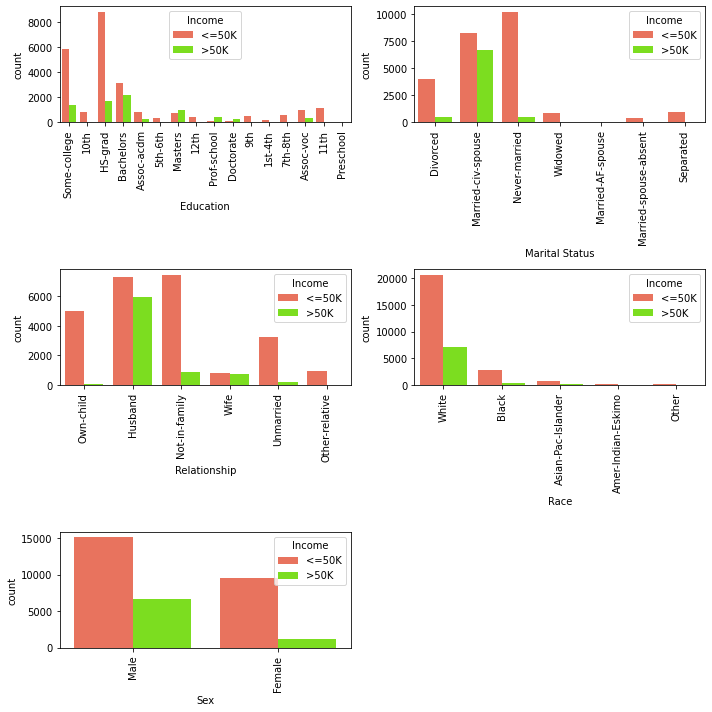

In [13]:
other_cat = ['Education', 'Marital Status', 'Relationship', 'Race', 'Sex']

plt.figure(figsize=(10,10))
for i in range(len(other_cat)):
    plt.subplot(3, 2, i+1)
    graf = sns.countplot(x=other_cat[i], data=df, hue='Income', palette=colors)
    graf.set_xticklabels(graf.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Acho que podemos inferir algumas coisas legais só olhando esses gráficos, muita informação fica clara quando vemos as distribuições separadas pelas rendas

Classes como "Masters", "Prof-school" e "Doctorate" apresentam mais pessoas com renda acima de 50K, e "Bachelors" tem uma proporção significamente alte
"Married-civ-spouse" apresenta uma maior taxa de pessoas com renda acima de 50K
Pessoas com filhos tem muito poucos membros com mais de 50K, "Husband" e "Wife" apresentam taxas interessantes
Brancos são a grande maioria total e de pessoas com mais de 50K
A maioria das pessoas consultadas é Homem, e estes tem uma maior proporção de pessoas com mais de 50K
Podemos ver que o dataset está meio desbalanceado, cerca de 75% das observações são para pessoas com renda menor de 50K

# Pré-processamento dos dados:

---

Algumas colunas como "Country" se mostraram notóriamente desnecessárias e supérfluas, porém ainda existem outras colunas que são um tanto redundantes e desnecessárias e, o propósito dessa seção é deixar nosso modelo pronto para ser diretamente colocado em alguns modelos de classificação.

Dessa forma teremos que lidar com dados faltantes, aplicar o One-Hot Encoder nas nossas variáveis categóricas e normalizar os dados numéricos.

Para essa parte é recomendado dar uma lida [aqui](https://medium.com/turing-talks/como-fazer-uma-limpeza-de-dados-completa-em-python-7abc9dfc19b8) um texto meu e da Vitoria sobre limpeza de dados

Para começo de conversa vou remover as colunas 'Country', 'Final Weight' e 'Education', isso pelo fato que a primeira ser totalmente desbalanceaba, enquanto a segunda é um valor estatístico de quantas pessoas na população teriam aqueles exatos parâmetros, já a terceira é redundante com a coluna 'Education-Num'

In [14]:
df.drop(['Country', 'Final Weight', 'Education'], axis=1, inplace=True)

Vamos remover nossos dados duplicados, já que a mesma observação repetidas vezes não vai nos ajudar nesse caso

In [15]:
df.drop_duplicates(keep='first', inplace=True)

Vamos conferir nossos dados faltantes agora

In [16]:
df.isna().sum()

Age                  0
Workclass         1616
Education-Num        0
Marital Status       0
Occupation        1623
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours per week       0
Income               0
dtype: int64

Podemos ver que apenas as colunas 'Workclass' e 'Occupation' apresentam dados faltantes e aparentemente existe alguma correlação, pois se uma linha tem uma dessas colunas nulas, provavelmente a outra é nula também e, mesmo essas 1623 linhas representarem um pouco mais de 5% dos dados, por simplicidade do problema vou apenas retirar essas linhas

Talvez essa não seja a abordagem mais indicada, já que poderíamos tentar imputar de alguma forma, porém como existe essa correlação entre esses dados faltantes, essas imputações podem pesar para o lado errado e não quero correr esse risco.

In [17]:
df[df['Workclass'].isnull() | df['Occupation'].isnull()]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Income
Id,,,,,,,,,,,,
16313,48,NaN,13,Married-civ-spouse,NaN,Husband,White,Male,0,0,6,<=50K
16315,30,NaN,9,Never-married,NaN,Own-child,White,Male,0,0,40,<=50K
16332,70,NaN,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,20,>50K
16340,58,NaN,8,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,<=50K
16350,67,NaN,14,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
48782,19,NaN,10,Never-married,NaN,Own-child,White,Female,594,0,10,<=50K
48797,42,NaN,10,Never-married,NaN,Not-in-family,White,Male,0,0,45,<=50K
48798,18,NaN,9,Never-married,NaN,Own-child,White,Male,0,0,60,<=50K


In [18]:
df.dropna(inplace=True)

Agora vamos já separar nossas colunas entre o tipo de variável, isso vai nos ajudar mais tarde, pois cada tipo de dato deve ter uma abordagem diferente

In [19]:
categorical = df[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex']].copy()
numerical = df[['Education-Num', 'Hours per week', 'Age']].copy()
sparse = df[['Capital Gain', 'Capital Loss']].copy()
target = df[['Income']].copy()

categorical.reset_index(drop=True, inplace=True)
numerical.reset_index(drop=True, inplace=True)
sparse.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

Primeiramente vamos aplicar o OneHot Encoding com a função get_dummies do pandas, o parâmetro `drop_first` indica que de K categorias teremos K-1 variáveis dummy, isso é útil pelo fato que a variável faltante pode ser inferida se todas as outras forem 0, exemplo no caso binário de 'Sex_Male', se for 0 é pelo fato de um 'Sex_Female' virtual ser 1 e vice-versa, isso pode ser expandido para n dimensões.

In [20]:
categorical = pd.get_dummies(categorical, drop_first=True)
categorical

,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Marital Status_Married-AF-spouse,Marital Status_Married-civ-spouse,Marital Status_Married-spouse-absent,Marital Status_Never-married,Marital Status_Separated,Marital Status_Widowed,Occupation_Armed-Forces,Occupation_Craft-repair,Occupation_Exec-managerial,Occupation_Farming-fishing,Occupation_Handlers-cleaners,Occupation_Machine-op-inspct,Occupation_Other-service,Occupation_Priv-house-serv,Occupation_Prof-specialty,Occupation_Protective-serv,Occupation_Sales,Occupation_Tech-support,Occupation_Transport-moving,Relationship_Not-in-family,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27128,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
27129,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
27130,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
27131,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Vamos usar agora um normalizador de Máximo-Mínimo para deixar nossas variáveis numéricas entre os valores 0 e 1

In [21]:
from sklearn.preprocessing import MinMaxScaler

MM = MinMaxScaler(feature_range=(0, 1))

numerical = MM.fit_transform(numerical)
numerical = pd.DataFrame({
    'Education-Num' : numerical[:, 0],
    'Hours per week' : numerical[:, 1],
    'Age' : numerical[:, 2],
})

Para os dados esparsos de Capital Gain e Capital Loss, vou fazer uma outra abordagem: criar uma variável que guarda o "Capital Total = Gain - Loss" e em seguida aplicar um binarizer com um determinado threshold.

In [22]:
from sklearn.preprocessing import Binarizer

capital_total = sparse['Capital Gain'] - sparse['Capital Loss']

bi = Binarizer(threshold=20000)
capital_total = bi.transform(np.array(capital_total).reshape(-1, 1))

sparse = pd.DataFrame(capital_total, columns=['Capital Total'])

Vamos só transformar nosso target para uma variável binária e já denotar a nomenclatura usual de y

In [23]:
target = pd.get_dummies(target, drop_first=True)
target.columns = ['Income']
y = target['Income'].to_numpy()

Vamos agora criar uma funçãozinha para ajudar a montar nosso dataset de variáveis X e em seguida já juntar os datasets

In [24]:
def montar(clean, df):
    for col in df.columns:
        clean[col] = df[col]
    return clean

X = pd.DataFrame()

X = montar(X, categorical)
X = montar(X, numerical)
X = montar(X, sparse)

# Aplicando nos dados de validação:

---

Vamos aplicar os processos de limpeza utilizados anteriormente nos nossos dados de validação

In [25]:
validation = pd.read_csv('test_data.csv', na_values='?')
ids = validation['Id']
validation.columns = ['Id'] + col_names[:-1]
validation.drop(['Id', 'Country', 'Final Weight', 'Education'], axis=1, inplace=True)

val_cat = validation[['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex']].copy()
val_num = validation[['Education-Num', 'Hours per week', 'Age']].copy()
val_spr = validation[['Capital Gain', 'Capital Loss']].copy()

val_cat.reset_index(drop=True, inplace=True)
val_num.reset_index(drop=True, inplace=True)
val_spr.reset_index(drop=True, inplace=True)

val_cat = pd.get_dummies(val_cat, drop_first=True)

val_num = MM.transform(val_num)
val_num = pd.DataFrame({
    'Education-Num'  : val_num[:, 0],
    'Hours per week' : val_num[:, 1],
    'Age'            : val_num[:, 2],
})

spr_total = val_spr['Capital Gain'] - val_spr['Capital Loss']
spr_total = bi.transform(np.array(spr_total).reshape(-1, 1))
val_spr = pd.DataFrame(spr_total, columns=['Capital Total'])

validation = pd.DataFrame()
validation = montar(validation, val_cat)
validation = montar(validation, val_num)
validation = montar(validation, val_spr)

validation['Id'] = ids
validation.drop('Workclass_Never-worked', axis=1, inplace=True)
validation.set_index('Id', inplace=True)

# Modelos de classificação:

---

Vamos começar importando todos os modelos que queremos testar

In [26]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Vamos agora criar nosso dicionário com os modelos e nosso futuro dicionário de scores

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

models = {
    'Logistic'           :   LogisticRegression(random_state=42, solver='newton-cg'),
    'SVC'                :   SVC(gamma='auto'),
    'LinearSVC'          :   LinearSVC(random_state=42, tol=1e-5),
    'DecisionTree'       :   DecisionTreeClassifier(random_state=42, criterion='gini'),
    'Dummy'              :   DummyClassifier(),
    'AdaBoost'           :   AdaBoostClassifier(n_estimators=100, random_state=42),
    'RandomForest'       :   RandomForestClassifier(max_depth=4, random_state=42),
    'GradientBoosting'   :   GradientBoostingClassifier(random_state=42),
    'KNeighbors'         :   KNeighborsClassifier(n_neighbors=24),         
    'Ridge'              :   RidgeClassifier(),   
    'SGD'                :   SGDClassifier(max_iter=1000, tol=1e-3),      
}

scores = {
    'Nomes'      :   [],
    'Acurácia'   :   [],
    'F1-Score'   :   [],
    'ROC-AUC'    :   [],
}

In [28]:
def gera_metricas(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1s = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    scores['Nomes'].append(name)
    scores['Acurácia'].append(acc)
    scores['F1-Score'].append(f1s)
    scores['ROC-AUC'].append(auc)

for name in models:
    gera_metricas(name, models[name])

models = pd.DataFrame(scores)
models.set_index('Nomes', inplace=True)
models

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


,Acurácia,F1-Score,ROC-AUC
Nomes,,,
Logistic,0.828266,0.626003,0.743293
SVC,0.819421,0.595710,0.723231
LinearSVC,0.827713,0.627342,0.744633
DecisionTree,0.754929,0.514953,0.676275
Dummy,0.627418,0.265795,0.508162
AdaBoost,0.830293,0.640094,0.754166
RandomForest,0.804865,0.453842,0.644676
GradientBoosting,0.829740,0.630695,0.746474
KNeighbors,0.819237,0.612712,0.736290


Vamos agora achar nosso melhor modelo

In [29]:
models.loc[models.idxmax()]

,Acurácia,F1-Score,ROC-AUC
Nomes,,,
AdaBoost,0.830293,0.640094,0.754166
AdaBoost,0.830293,0.640094,0.754166
AdaBoost,0.830293,0.640094,0.754166


E o AdaBoost ganhou em todos os aspectos, vamos usar ele então para nossa etapa de submissão

# Submissão:

---

In [30]:
model = AdaBoostClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(validation)

submission = pd.DataFrame()
submission['Id'] = ids
submission['Income'] = predictions

submission['Income'].replace({0: '<=50K', 1: '>50K'}, inplace=True)

submission.to_csv('submission.csv', index=False)